# Course Project 02: Artificial Neural Network Model with Custom Dataset

#### Name: Nguyen Mai Dinh, Le (Demi, Le)
#### ID: 300312139

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.ops import MLP

#Preprocessing images for MLP
from MLP.ImagePreprocessing import ImgObject
from MLP.CustomDataset import MLPDataset, CNNDataset

#Metrics

from sklearn import metrics

#MLP
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader


%matplotlib inline

## Part 1: Dataset Selection and Exploration – 20%

### 1.1. Import + Load dataset

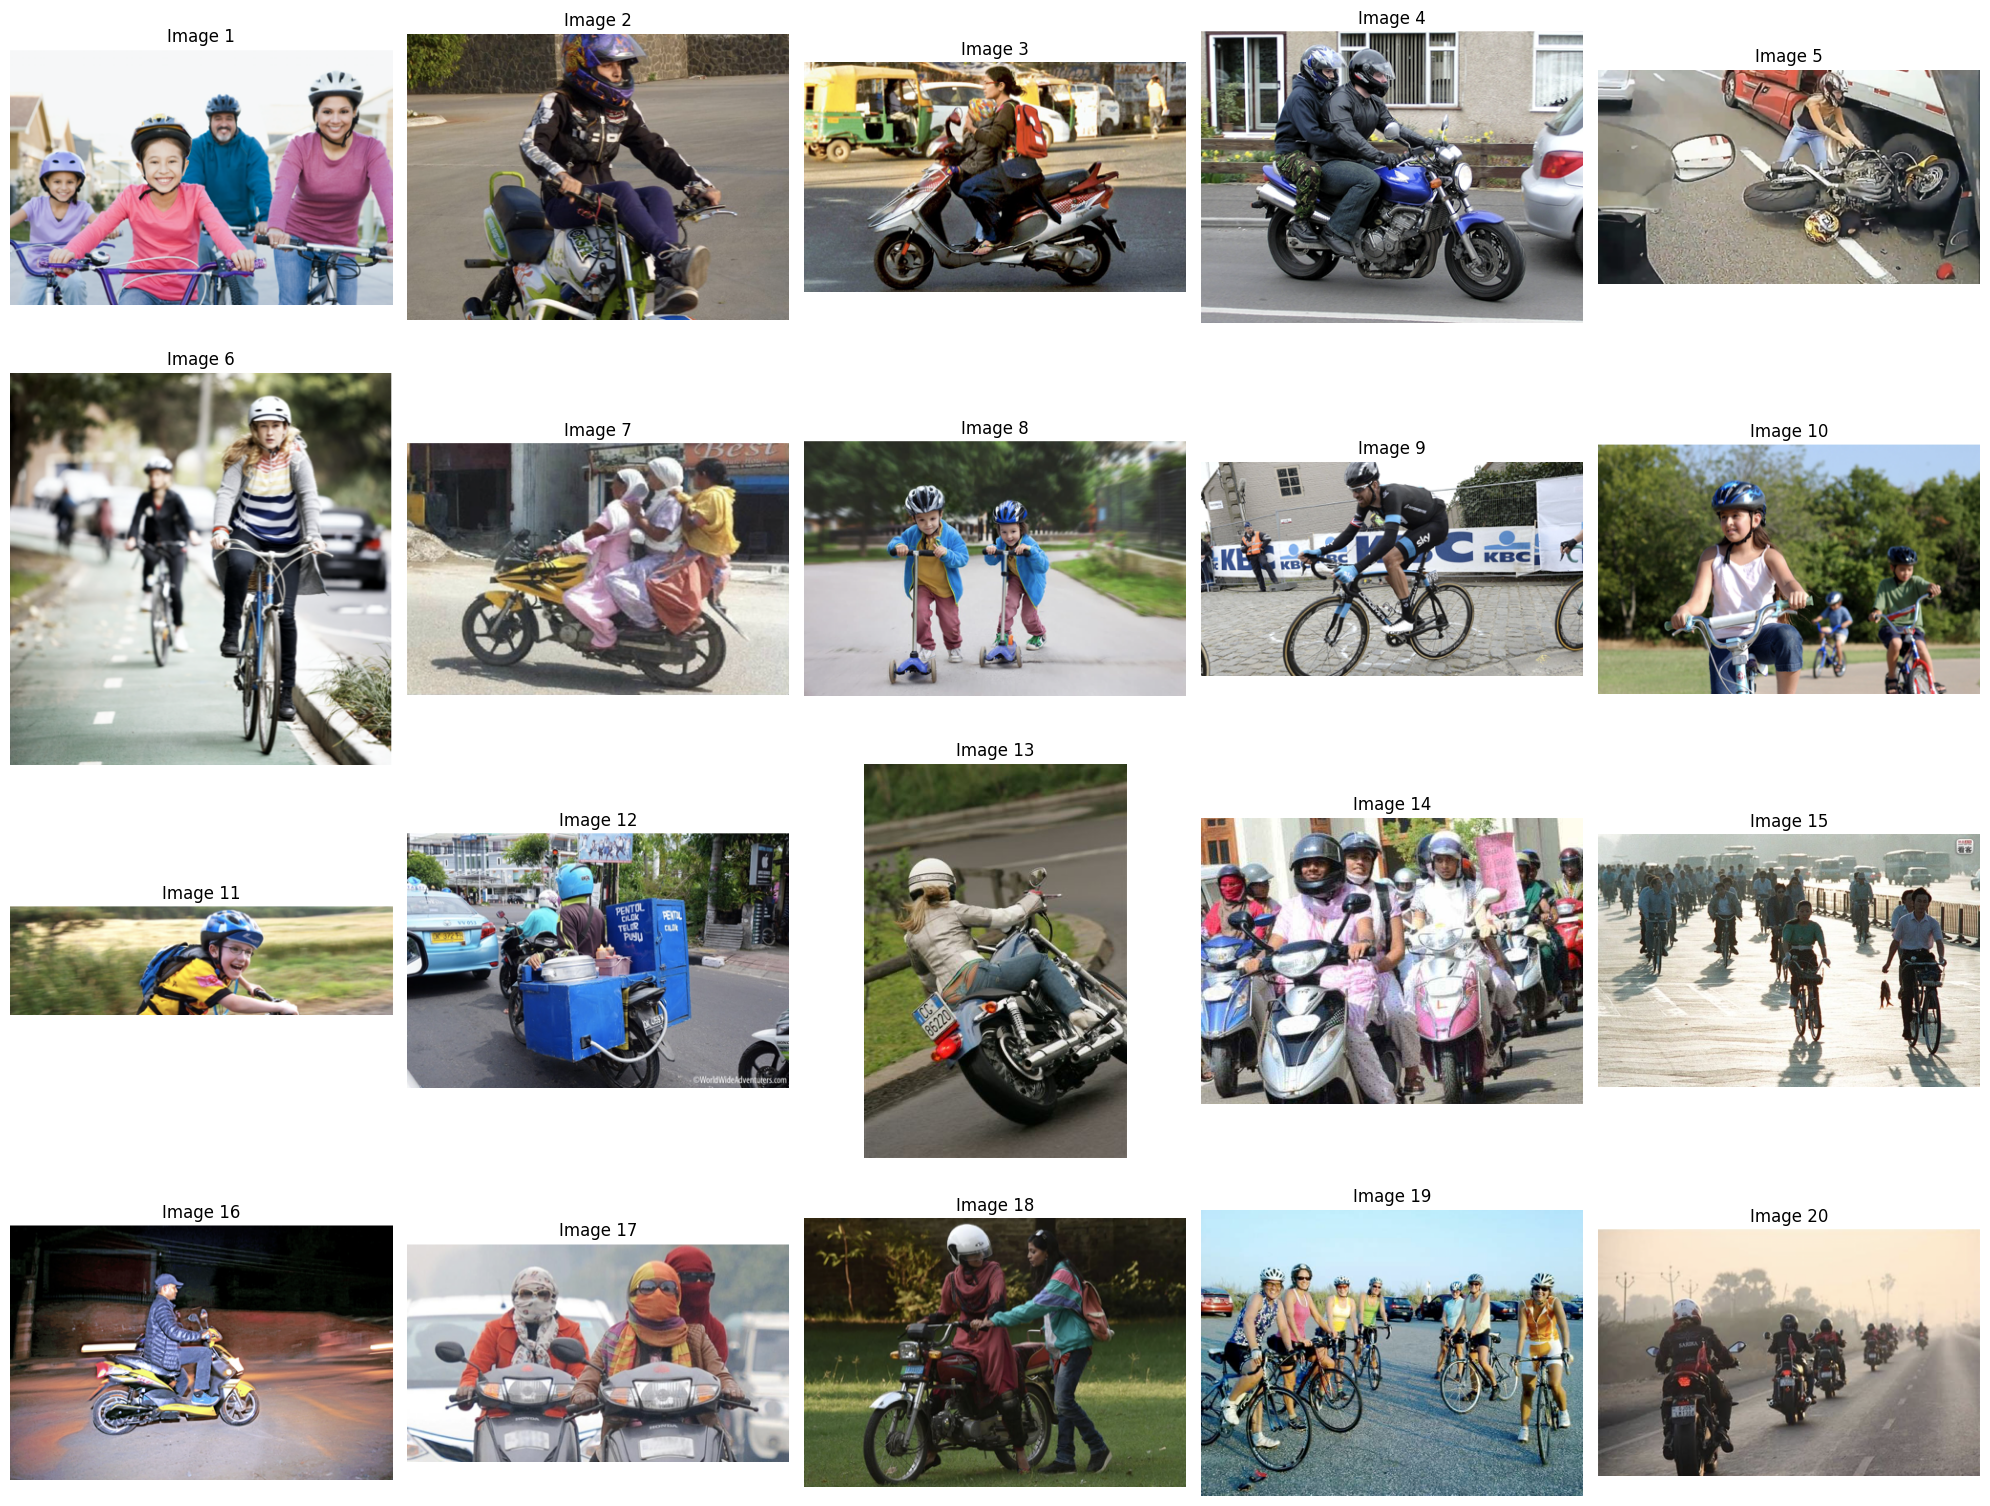

In [2]:
img_path = "images/"
annot_path = "annotations/"
valid_extensions =  {'.jpg', '.jpeg', '.png'}
img_list = []
annot_list = []

for img_file in os.listdir(img_path):
 
    name, ext = os.path.splitext(img_file)
    if ext.lower() in valid_extensions:
        img_path = "images/" + img_file
        img_list.append(img_path)
        label_path = "annotations/" + name + ".xml"
        annot_list.append(label_path)

img_preview = img_list[:20]
n = len(img_preview)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))

axes = axes.flatten()

for i, path in enumerate(img_preview):
    ax = axes[i]
    ax.imshow(Image.open(path))
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

### 1.2. Explain your dataset choice

#### 1.2.a. Attach the link and a screenshot (like the sample below) of the dataset you chose in your ipynb from one of the resources.

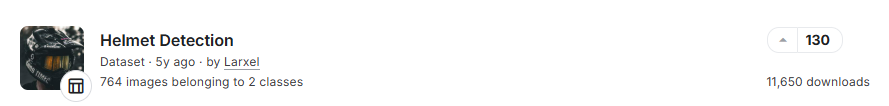

Source: https://www.kaggle.com/datasets/andrewmvd/helmet-detection/data

#### 1.2.b. A short description, including the targeted values (classes) and features.

This dataset contains 764 images of 2 distinct classes for the objective of helmet detection.
Bounding box annotations are provided in the PASCAL VOC format
The classes are:
* With helmet;
* Without helmet.

Initially, my main objective was to build an object detection model capable of identifying helmets by drawing bounding boxes around them.
However, given the tight project timeline and submission deadline, I decided to focus on the more feasible objective of image classification for this assignment.

To optimize the workflow and save time on image processing, I leveraged an existing object detection dataset.
Specifically, I cropped the labeled bounding boxes from the parent images to create a dedicated training dataset for helmet/no-helmet classification.
This approach allowed me to maintain a strong connection to the original detection task while adapting to the practical constraints of the project timeline.

### 1.3. Explore Data - 80%

#### 1.3.1. Check number of images

In [3]:
len(img_list)

764

#### 1.3.2. Image & Object Overview

Since the dataset consists of images intended for object detection — where the goal is to localize objects using bounding boxes rather than simply assigning a single label (0 or 1) to the entire image — it is necessary to analyze both the overall image information and the details of the objects contained within each image.

In [4]:
img_overview_list = []
obj_overview_list = []
for img, annot in zip(img_list, annot_list):
    object_ = ImgObject(img, annot)
    img_overview_list.append(object_.img_overview())
    obj_overview_list.extend(object_.obj_overview())
img_overview_df = pd.DataFrame(img_overview_list, columns=["file_name", "height", "width", "num_channels"])
obj_overview_df = pd.DataFrame(obj_overview_list, columns=["obj_id", "class", "xmin", "ymin", "xmax", "ymax"])
img_overview_df

file_name  height  width  num_channels
0      BikesHelmets0     267    400             3
1      BikesHelmets1     300    400             3
2     BikesHelmets10     241    400             3
3    BikesHelmets100     305    400             3
4    BikesHelmets101     225    400             3
..               ...     ...    ...           ...
759   BikesHelmets95     320    320             3
760   BikesHelmets96     208    400             3
761   BikesHelmets97     450    600             3
762   BikesHelmets98     231    400             3
763   BikesHelmets99     245    400             3

[764 rows x 4 columns]

#### 1.3.3. Image & Object Descriptive Summary

We analyze the descriptive statistics of the images and objects to identify whether any images are exceptionally large or small compared to the overall dataset, and whether any objects are unusually large (since objects are typically expected to be smaller than the full image size).
Additionally, we check for variations in the number of color channels across the dataset.

In [5]:
img_overview_df.describe()

height       width  num_channels
count  764.000000  764.000000         764.0
mean   298.595550  405.154450           3.0
std     75.225202   72.225562           0.0
min    114.000000  150.000000           3.0
25%    250.000000  400.000000           3.0
50%    268.000000  400.000000           3.0
75%    341.000000  400.000000           3.0
max    600.000000  600.000000           3.0

In [6]:
obj_overview_df.describe()

class           xmin          ymin           xmax           ymax
count  1451.000000    1451.000000   1451.000000    1451.000000    1451.000000
mean      0.337009    1978.237078    331.101999    2402.440386     691.375603
std       0.472851   18674.611162   3912.823258   21894.340899    6292.904834
min       0.000000       2.000000      0.000000      27.000000      25.000000
25%       0.000000     123.000000     17.500000     165.000000      68.000000
50%       0.000000     181.000000     42.000000     225.000000      90.000000
75%       1.000000     247.000000     72.000000     288.000000     115.000000
max       1.000000  334800.000000  72900.000000  355600.000000  106800.000000

**Observation**: 
* The number of color channels is consistent across images (all are RGB), with no variation detected.
* Mean is not so different with median, indicating size of images are stable with no outliers

#### 1.3.4. Checking class ratio: 
Checking class ratio to identify if they are balance or imbalance, thus, making better choice for evaluation metrics

In [7]:
obj_overview_df['class'].value_counts(normalize=True) * 100

class
0    66.299104
1    33.700896
Name: proportion, dtype: float64

**Observation:**
* 66% of the objects are helmet-wearing.
* 33% of the objects are non-helmet (no helmet).
  
→ Indicates class imbalance.

#### 1.3.5. Checking outliers & data distribution with Boxplot

Boxplot is useful in detecting outliers which mostly lie above upper bound and belowe lower bound

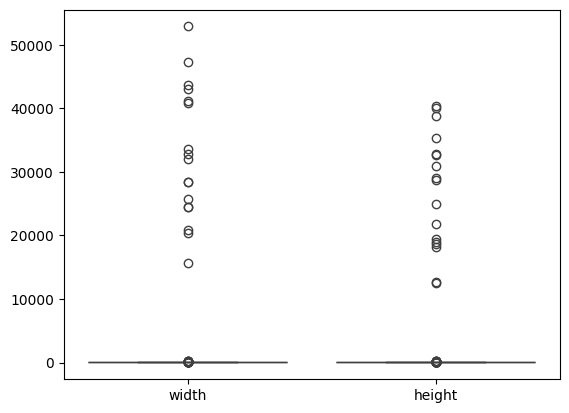

In [8]:
obj_overview_df['width'] = obj_overview_df['xmax'] - obj_overview_df['xmin']
obj_overview_df['height'] = obj_overview_df['ymax'] - obj_overview_df['ymin']
sns.boxplot(data=obj_overview_df[['width', 'height']])
plt.show()

In [9]:
obj_overview_df.loc[(obj_overview_df['width'] > 600) | (obj_overview_df['height'] > 600)]

obj_id  class    xmin   ymin    xmax    ymax  width  \
10    BikesHelmets103.png_0      1  149282  10520  177697   32350  28415   
96    BikesHelmets140.png_0      1  192641   2403  245507   42720  52866   
232   BikesHelmets205.png_0      0  112047   2028  155142   27040  43095   
372   BikesHelmets279.png_0      0   57200   2400   98400   42400  41200   
477   BikesHelmets326.png_0      0   34200   3200   60000   42000  25800   
515   BikesHelmets343.png_0      0  249264  26093  296552   54876  47288   
733   BikesHelmets441.png_0      1  112000   3000  136400   21900  24400   
741   BikesHelmets444.png_0      1   52000   1272   67600   13992  15600   
907   BikesHelmets530.png_0      0  104918   4272  145764   35244  40846   
1084  BikesHelmets616.png_2      0  214800  50400  235200   68600  20400   
1206  BikesHelmets671.png_1      1  334800  54000  355600   66480  20800   
1278  BikesHelmets706.png_1      1  139600  15000  164000   34500  24400   
1354   BikesHelmets75.png_0      0  172000  70800  204800  103500  32800   
1355   BikesHelmets75.png_1      0  287600  72900  321200  102000  33600   
1356   BikesHelmets75.png_2      0  164800  71400  208400  106800  43600   
1398  BikesHelmets764.png_0      0   71600  20000  103600   52800  32000   
1406   BikesHelmets80.png_0      1  155600    896  184000   19488  28400   

      height  
10     21830  
96     40317  
232    25012  
372    40000  
477    38800  
515    28783  
733    18900  
741    12720  
907    30972  
1084   18200  
1206   12480  
1278   19500  
1354   32700  
1355   29100  
1356   35400  
1398   32800  
1406   18592

**Observation:**

Based on the boxplot, there are many images where object positions exceed the image size (maximum image size is 600 × 600), indicating that these objects are potential outliers.

## Part 2: Data Preprocessing & Feature Engineering – 20%

### 2.1. Merge Object Table with Image Table for Detailed Analysis

In [10]:
obj_overview_df['file_name'] = obj_overview_df['obj_id'].str.split('.png').str[0]
obj_overview_df

obj_id  class  xmin  ymin  xmax  ymax  width  height  \
0      BikesHelmets0.png_0      0    29   105    82   160     53      55   
1      BikesHelmets0.png_1      0   122    66   193   154     71      88   
2      BikesHelmets0.png_2      0   201    43   246    98     45      55   
3      BikesHelmets0.png_3      0   307    17   371   107     64      90   
4      BikesHelmets1.png_0      0   161     0   252    82     91      82   
...                    ...    ...   ...   ...   ...   ...    ...     ...   
1446  BikesHelmets98.png_0      1   116    50   146    85     30      35   
1447  BikesHelmets99.png_0      0   268    59   295    86     27      27   
1448  BikesHelmets99.png_1      1   161    52   193    83     32      31   
1449  BikesHelmets99.png_2      1    63    57    90    86     27      29   
1450  BikesHelmets99.png_3      0   325    68   353   102     28      34   

           file_name  
0      BikesHelmets0  
1      BikesHelmets0  
2      BikesHelmets0  
3      BikesHelmets0  
4      BikesHelmets1  
...              ...  
1446  BikesHelmets98  
1447  BikesHelmets99  
1448  BikesHelmets99  
1449  BikesHelmets99  
1450  BikesHelmets99  

[1451 rows x 9 columns]

In [11]:
merge = pd.merge(img_overview_df, obj_overview_df, on="file_name", how="outer")
merge

file_name  height_x  width_x  num_channels                obj_id  \
0      BikesHelmets0       267      400             3   BikesHelmets0.png_0   
1      BikesHelmets0       267      400             3   BikesHelmets0.png_1   
2      BikesHelmets0       267      400             3   BikesHelmets0.png_2   
3      BikesHelmets0       267      400             3   BikesHelmets0.png_3   
4      BikesHelmets1       300      400             3   BikesHelmets1.png_0   
...              ...       ...      ...           ...                   ...   
1449  BikesHelmets98       231      400             3  BikesHelmets98.png_0   
1450  BikesHelmets99       245      400             3  BikesHelmets99.png_0   
1451  BikesHelmets99       245      400             3  BikesHelmets99.png_1   
1452  BikesHelmets99       245      400             3  BikesHelmets99.png_2   
1453  BikesHelmets99       245      400             3  BikesHelmets99.png_3   

      class   xmin   ymin   xmax   ymax  width_y  height_y  
0       0.0   29.0  105.0   82.0  160.0     53.0      55.0  
1       0.0  122.0   66.0  193.0  154.0     71.0      88.0  
2       0.0  201.0   43.0  246.0   98.0     45.0      55.0  
3       0.0  307.0   17.0  371.0  107.0     64.0      90.0  
4       0.0  161.0    0.0  252.0   82.0     91.0      82.0  
...     ...    ...    ...    ...    ...      ...       ...  
1449    1.0  116.0   50.0  146.0   85.0     30.0      35.0  
1450    0.0  268.0   59.0  295.0   86.0     27.0      27.0  
1451    1.0  161.0   52.0  193.0   83.0     32.0      31.0  
1452    1.0   63.0   57.0   90.0   86.0     27.0      29.0  
1453    0.0  325.0   68.0  353.0  102.0     28.0      34.0  

[1454 rows x 12 columns]

### 2.2. Check if there is any image that has no object (Missing values)

In [12]:
merge.loc[merge['obj_id'].isnull()]

file_name  height_x  width_x  num_channels obj_id  class  xmin  \
525    BikesHelmets35       295      400             3    NaN    NaN   NaN   
771   BikesHelmets459       225      400             3    NaN    NaN   NaN   
1328  BikesHelmets735       267      400             3    NaN    NaN   NaN   

      ymin  xmax  ymax  width_y  height_y  
525    NaN   NaN   NaN      NaN       NaN  
771    NaN   NaN   NaN      NaN       NaN  
1328   NaN   NaN   NaN      NaN       NaN

**Observation**: There are 2 main problems of the dataset: 

* There are images with irrelevant object size
* There are imahes with no objects

**Solution:** Drop them

### 2.3. Drop images with: no objects or objects that have irrelevant size

In [13]:
drop_list = merge['file_name'].loc[
    (merge['height_x'] <= merge['height_y']) | 
    (merge['width_x'] <= merge['width_y']) | 
    (merge['obj_id'].isnull())
]
drop_list.unique()

array(['BikesHelmets103', 'BikesHelmets140', 'BikesHelmets205',
       'BikesHelmets279', 'BikesHelmets326', 'BikesHelmets343',
       'BikesHelmets35', 'BikesHelmets441', 'BikesHelmets444',
       'BikesHelmets459', 'BikesHelmets530', 'BikesHelmets616',
       'BikesHelmets671', 'BikesHelmets706', 'BikesHelmets735',
       'BikesHelmets75', 'BikesHelmets764', 'BikesHelmets80'],
      dtype=object)

In [14]:
img_list_df = pd.Series(img_list)
annot_list_df = pd.Series(annot_list)
filtered_img_list = []
filtered_annot_list = []

img_names = img_list_df.apply(lambda x: os.path.splitext(os.path.basename(x))[0])
drop_indexes = img_names[img_names.isin(drop_list)].index

for i, img in enumerate(img_list):
    if i not in drop_indexes:
        filtered_img_list.append(img_list[i])
        filtered_annot_list.append(annot_list[i])

In [15]:
index_to_drop = merge[merge['file_name'].isin(drop_list)].index
merge = merge.drop(index_to_drop)
merge

file_name  height_x  width_x  num_channels                obj_id  \
0      BikesHelmets0       267      400             3   BikesHelmets0.png_0   
1      BikesHelmets0       267      400             3   BikesHelmets0.png_1   
2      BikesHelmets0       267      400             3   BikesHelmets0.png_2   
3      BikesHelmets0       267      400             3   BikesHelmets0.png_3   
4      BikesHelmets1       300      400             3   BikesHelmets1.png_0   
...              ...       ...      ...           ...                   ...   
1449  BikesHelmets98       231      400             3  BikesHelmets98.png_0   
1450  BikesHelmets99       245      400             3  BikesHelmets99.png_0   
1451  BikesHelmets99       245      400             3  BikesHelmets99.png_1   
1452  BikesHelmets99       245      400             3  BikesHelmets99.png_2   
1453  BikesHelmets99       245      400             3  BikesHelmets99.png_3   

      class   xmin   ymin   xmax   ymax  width_y  height_y  
0       0.0   29.0  105.0   82.0  160.0     53.0      55.0  
1       0.0  122.0   66.0  193.0  154.0     71.0      88.0  
2       0.0  201.0   43.0  246.0   98.0     45.0      55.0  
3       0.0  307.0   17.0  371.0  107.0     64.0      90.0  
4       0.0  161.0    0.0  252.0   82.0     91.0      82.0  
...     ...    ...    ...    ...    ...      ...       ...  
1449    1.0  116.0   50.0  146.0   85.0     30.0      35.0  
1450    0.0  268.0   59.0  295.0   86.0     27.0      27.0  
1451    1.0  161.0   52.0  193.0   83.0     32.0      31.0  
1452    1.0   63.0   57.0   90.0   86.0     27.0      29.0  
1453    0.0  325.0   68.0  353.0  102.0     28.0      34.0  

[1411 rows x 12 columns]

### 2.4. Data Visualization

### 2.4.1. Histogram

The histogram is an appropriate visualization in this context as it provides a clear overview of the distribution range of image dimensions and object dimensions. This allows for more informed decisions regarding standardized resizing dimensions during preprocessing.

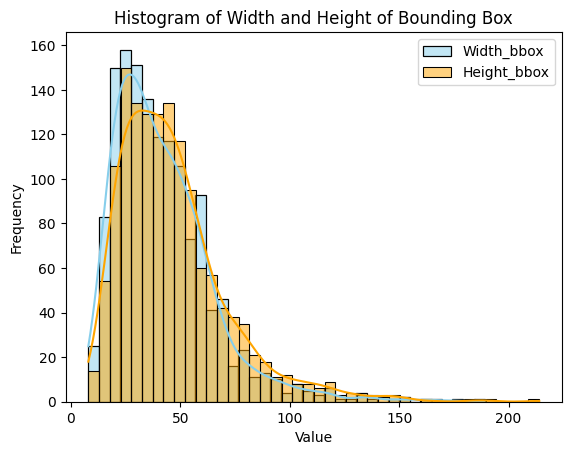

In [16]:
sns.histplot(data=merge, x='width_y', kde=True, color='skyblue', label='Width_bbox')
sns.histplot(data=merge, x='height_y', kde=True, color='orange', label='Height_bbox')

plt.legend()
plt.title("Histogram of Width and Height of Bounding Box")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

**Observation:**

The majority of objects exhibit dimensions approximately between 30×30 and 50×50 pixels, with a predominantly square shape.

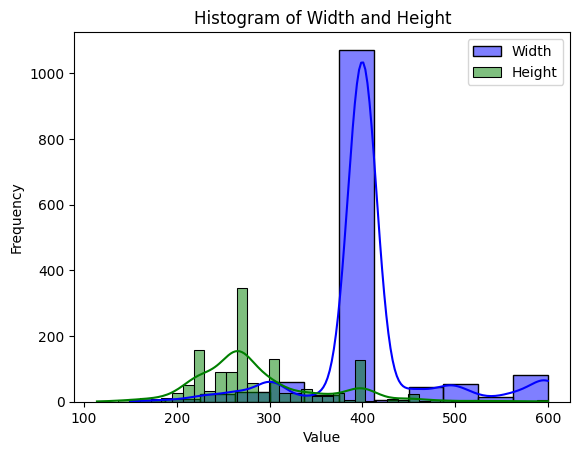

In [17]:
sns.histplot(data=merge, x='width_x', kde=True, color='blue', label='Width')
sns.histplot(data=merge, x='height_x', kde=True, color='green', label='Height')

plt.legend()
plt.title("Histogram of Width and Height")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

**Observation:**

The distribution of image widths and heights indicates that the majority of images have widths concentrated around 400 pixels, while heights are more variable, with a noticeable peak near 270 pixels. This suggests a consistent image width across the dataset

### 2.4.2. Bar Chart

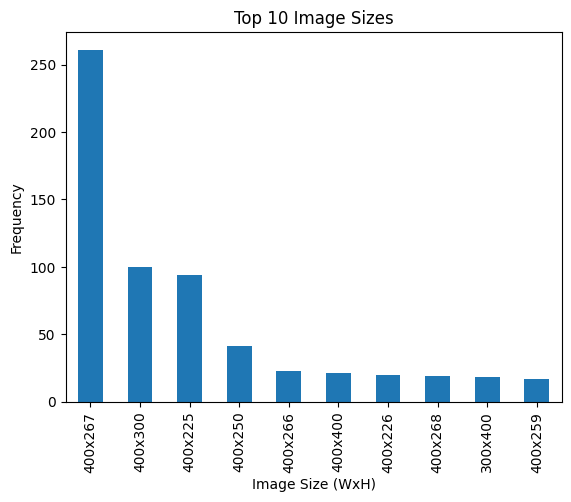

In [18]:
merge['size_str'] = merge['width_x'].astype(str) + 'x' + merge['height_x'].astype(str)
merge['size_str'].value_counts().head(10).plot(kind='bar', title='Top 10 Image Sizes')
plt.xlabel("Image Size (WxH)")
plt.ylabel("Frequency")
plt.show()

**Observation:**
The width is generally consistent, but height varies significantly. Resizing strategy should prioritize maintaining aspect ratio or padding to 400×300 or 400×400 for uniformity.

### 2.4. Feature Engineering

As previously mentioned, this dataset was originally curated for object detection—specifically helmet detection using bounding boxes. However, for this project, the goal is to repurpose the data for image classification using MLP (Multi-Layer Perceptron) and CNN (Convolutional Neural Network) models. The objective is to classify cropped image regions as either "With Helmet" or "Without Helmet".

Since the dataset does not come with direct image-label pairs suitable for classification, the strategy adopted involves cropping individual objects from the annotated images using their bounding box coordinates. These cropped objects are compiled into a new image list, and their corresponding class labels are extracted into a separate label list. This transformation allows the dataset to be used effectively for training classification models

#### 2.4.1. Crop Images and Extract into Two Lists: Images (in cv2 format) and Labels

To prepare the dataset for the image classification task, all annotated objects are cropped from their original images using the bounding box coordinates. These cropped object regions are stored as a list of images (in cv2 array format), and the corresponding labels are stored in a separate list.

A fixed crop size of 256 × 256 was selected. This decision is based on the following observations:
* Class imbalance exists, with the "No Helmet" class being underrepresented.
* Most cropped objects are relatively small (e.g., around 50 × 50 pixels).
* Resizing to a larger dimension preserves more visual context and detail, which may help the model better distinguish subtle features (e.g., the presence or absence of a helmet), especially for the minority class.

While this may introduce slightly longer training time, it is a trade-off for potentially improved model performance and generalization.

**Note for grading:** Please refer to MLP.ImagePreprocessing.ImgObject for the full implementation used in this step.

In [19]:
cropped_images_list = []
cropped_labels_list = []
for img, annot in zip(filtered_img_list, filtered_annot_list):
    object_ = ImgObject(img, annot)
    cropped_images, cropped_labels = object_.crop_object()
    cropped_images_list.extend(cropped_images)
    cropped_labels_list.extend(cropped_labels)

('BikesHelmets0.png_0', 0, 29, 105, 82, 160)
<class 'tuple'>
('BikesHelmets0.png_1', 0, 122, 66, 193, 154)
<class 'tuple'>
('BikesHelmets0.png_2', 0, 201, 43, 246, 98)
<class 'tuple'>
('BikesHelmets0.png_3', 0, 307, 17, 371, 107)
<class 'tuple'>
('BikesHelmets1.png_0', 0, 161, 0, 252, 82)
<class 'tuple'>
('BikesHelmets10.png_0', 1, 185, 4, 226, 41)
<class 'tuple'>
('BikesHelmets100.png_0', 0, 158, 20, 205, 71)
<class 'tuple'>
('BikesHelmets100.png_1', 0, 106, 11, 154, 64)
<class 'tuple'>
('BikesHelmets101.png_0', 0, 231, 2, 266, 42)
<class 'tuple'>
('BikesHelmets102.png_0', 0, 239, 23, 293, 83)
<class 'tuple'>
('BikesHelmets104.png_0', 0, 196, 61, 237, 112)
<class 'tuple'>
('BikesHelmets104.png_1', 0, 101, 43, 152, 102)
<class 'tuple'>
('BikesHelmets105.png_0', 0, 145, 2, 194, 51)
<class 'tuple'>
('BikesHelmets106.png_0', 0, 114, 34, 184, 108)
<class 'tuple'>
('BikesHelmets106.png_1', 0, 301, 106, 339, 146)
<class 'tuple'>
('BikesHelmets106.png_2', 0, 233, 150, 260, 176)
<class 'tuple'

#### 2.4.2. Check number of cropped images

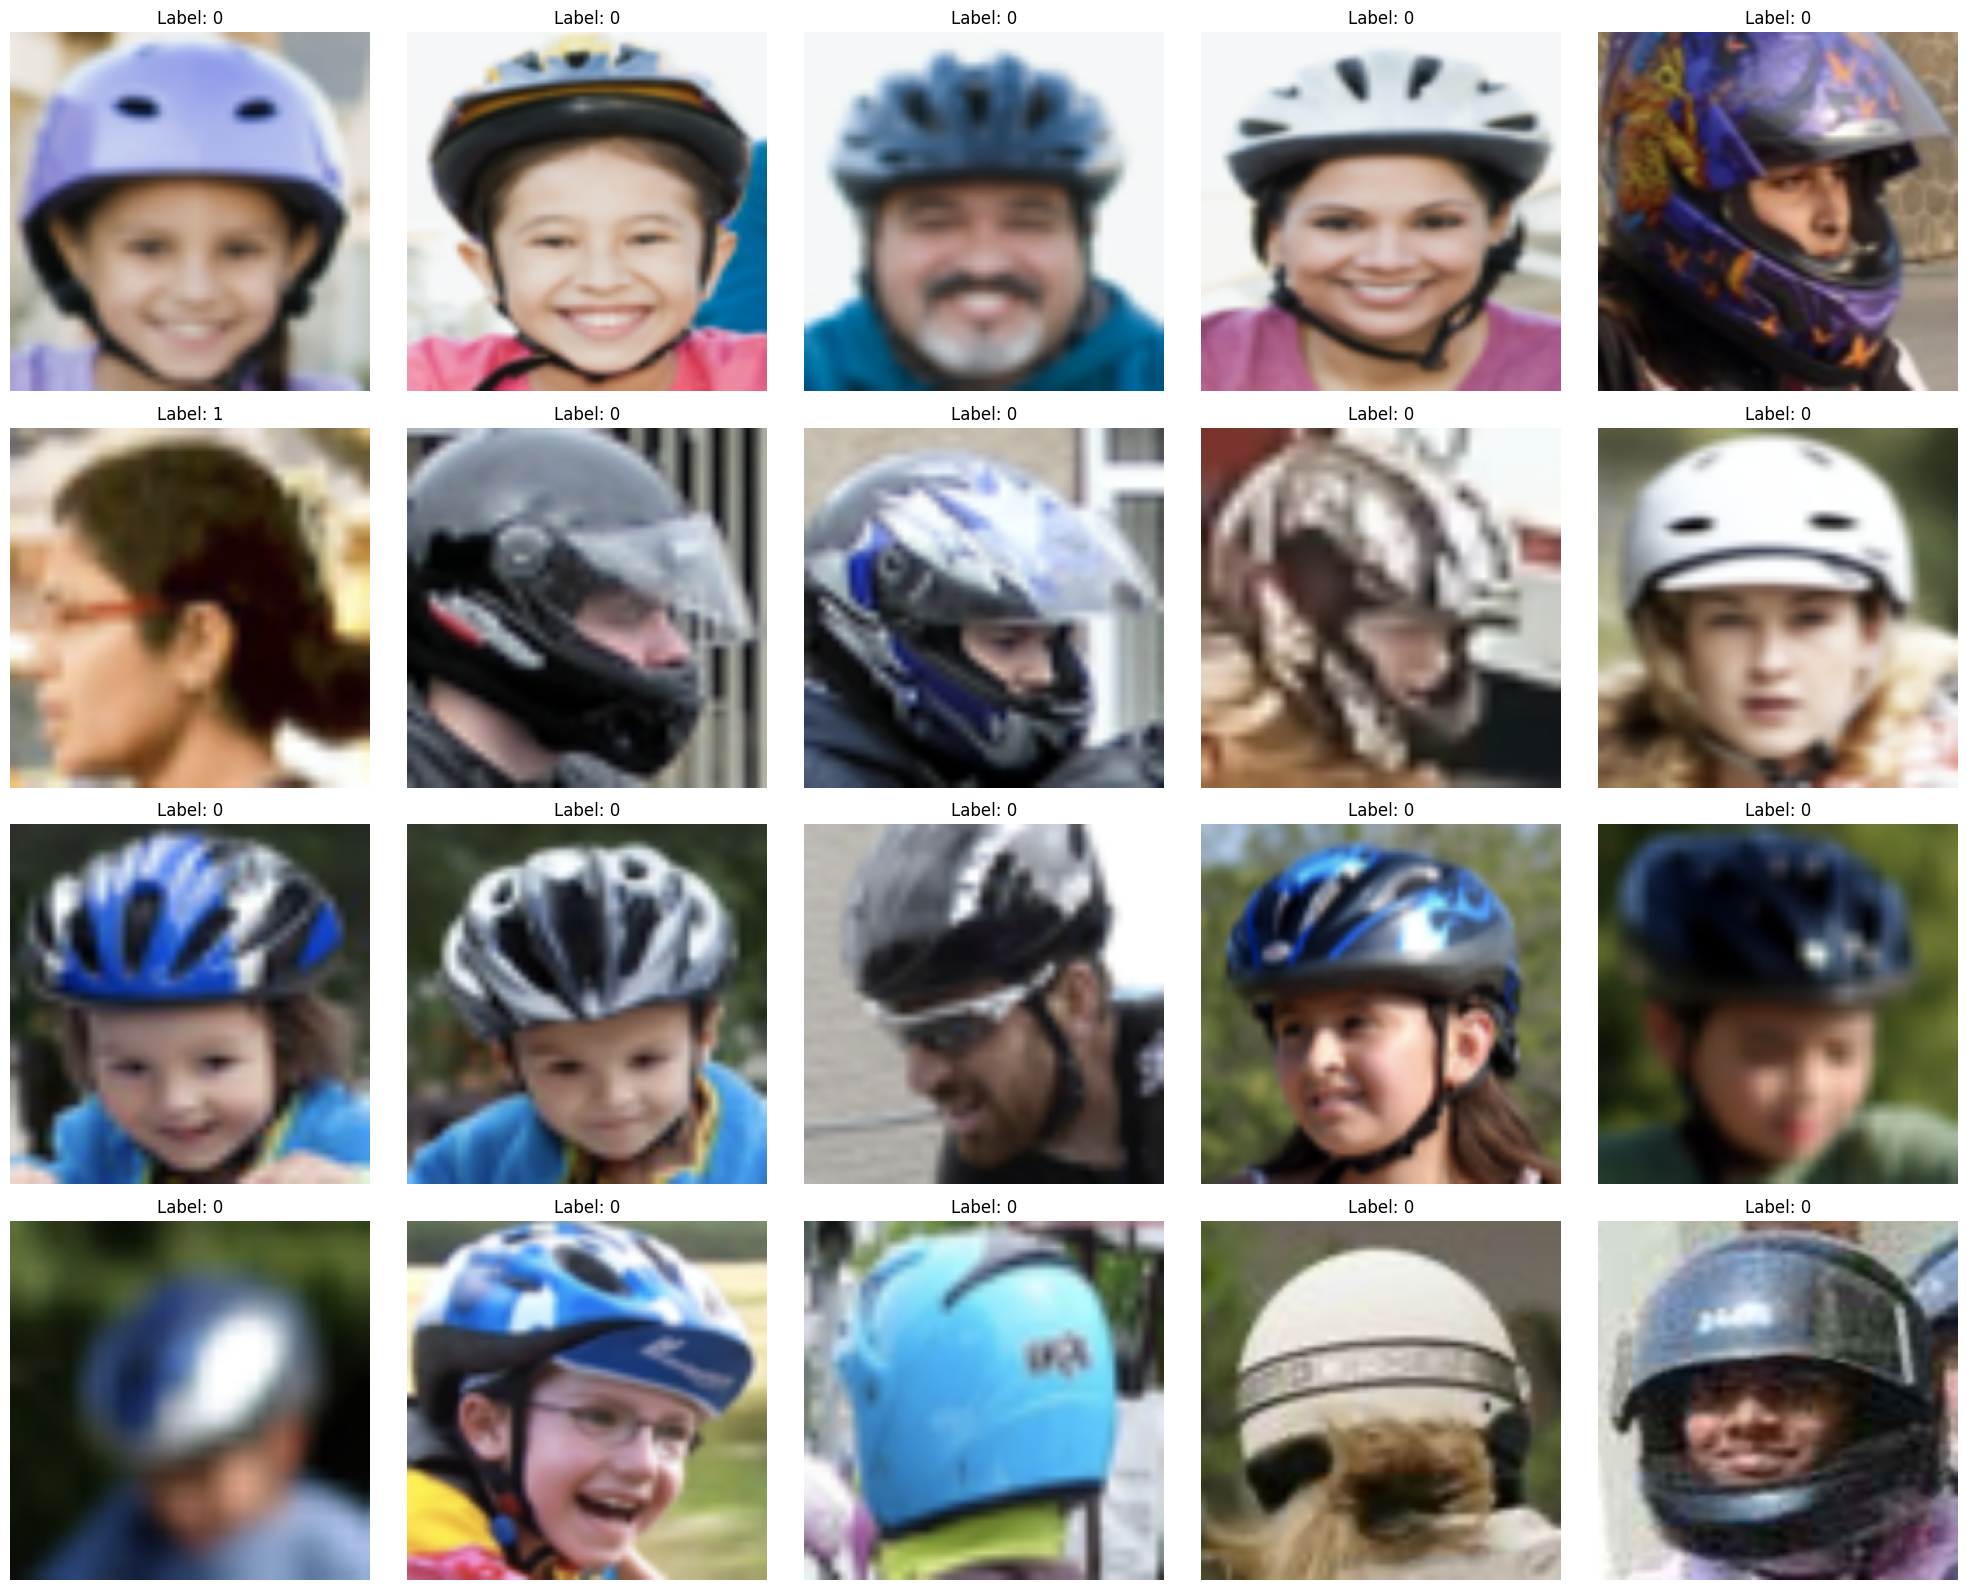

In [20]:
import matplotlib.pyplot as plt
import cv2

images = cropped_images_list[:20]  
labels = cropped_labels_list[:20]
n = len(images)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  

axes = axes.flatten()

for i, (img, label) in enumerate(zip(images, labels)):
    ax = axes[i]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(f"Label: {label}", fontsize=12)

plt.tight_layout()
plt.show()


In [21]:
len(cropped_images_list)

1411

#### 2.4.3. Transform to Tensor

Transforming image type to tensor is a must since this project intentionally uses Pytorch as the main library for training

In [22]:
transform_ = transforms.Compose([
    transforms.ToTensor()
])

tensor_list = [transform_(img) for img in cropped_images_list]

#### 2.4.4. Train-test-validation test

To preserve critical features, objects are cropped before resizing to avoid distortion, especially since helmets are small and resizing entire images would lose important details. Despite having 1411 images, a validation set is essential to objectively evaluate generalization, prevent overfitting, and optimize model performance on unseen data.

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(tensor_list, cropped_labels_list, test_size=0.3, random_state=42, stratify=cropped_labels_list)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X train:", len(X_train))
print("X test:", len(X_test))
print("X validation:", len(X_val))

X train: 987
X test: 212
X validation: 212


In [24]:
pd.Series(y_train).value_counts(normalize=True) * 100

0    66.56535
1    33.43465
Name: proportion, dtype: float64

#### 2.4.4. Normalize Images & Load into DataLoader
Custom datasets can have different pixel value distributions, so normalizing them ensures the model learns effectively without being biased by the dataset's unique scale or lighting conditions.

In [25]:
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
n = len(X_train)

for tensor in X_train:
    mean_sum += tensor.mean(dim=(1,2))
    std_sum += tensor.std(dim=(1,2))
mean = mean_sum/n
std = std_sum/n
print(mean)
print(std)

tensor([0.4105, 0.4282, 0.4677])
tensor([0.2287, 0.2272, 0.2332])


In [26]:
transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=mean)
])

training_data = MLPDataset(X_train, y_train, transform=transform)
val_data = MLPDataset(X_val, y_val, transform=transform)
test_data = MLPDataset(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
mlp_test_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

## Part 3 Train ANN Models– 30%

In [27]:
import torch.nn as nn

In [28]:
# Training function
def training_model(model, optimizer, epochs, train_dataloader, val_dataloader, lossfunction):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Lists to store history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch {epoch+1}:")

        # Iterate over training batches
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = lossfunction(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(train_dataloader)
        train_acc = correct / total * 100

        # Validate on the validation set
        val_loss, val_acc = evaluate_model(model, val_dataloader, return_loss_acc=True)

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc:.2f}%")
        print("-" * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, return_loss_acc=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    running_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        # Iterate over test batches
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    avg_loss = running_loss / len(test_loader)

    if return_loss_acc:
        return avg_loss, acc
    else:
        print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

# Plotting function for training curves        
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### 3.1. Multilayer Perceptron Models in PyTorch (MLP)

**Hyperparameter Justification**

* Input Layer to First Hidden Layer (256*256*3 → 2048): The high-dimensional pixel input is reduced to 2048 nodes, enabling the model to begin abstracting relevant features. A large hidden layer helps retain complex spatial relationships that might otherwise be lost during flattening.
* Progressive Reduction (2048 → 1024 → 256 → 64): Reducing the dimensions across layers captures increasingly abstract features important for classification.
* Final Output Layer (64 → 2): The final layer outputs two logits corresponding to the binary classes: helmet and no helmet.
* Batch Normalization: Since only 33% of objects are No Helmet, the model risks being biased toward the majority class. BatchNorm1d after each layer helps stabilize learning even with imbalanced data.
* Dropout: Dropout rates of 0.4–0.5 are used to reduce overfitting, especially critical for this dataset where the dataset contains only 1411 cropped images, which is relatively small given the feature space. 
* ReLU Activation Function: ReLU avoids the vanishing gradient problem seen in sigmoid and tanh, where gradients become tiny for large or small inputs, slowing training. Especially images with large size (256x256x3), the feature number is really large, so putational cost is a problem
* Adam optimizer (lr=0.003) provides adaptive learning, beneficial for sparse gradients from large input features.
* He initialization supports ReLU activations by preserving signal flow across layers, which is especially important in deep MLPs with large input variance.
* CrossEntropyLoss is chosen for binary classification.

In [29]:
mlp_model = nn.Sequential(

    nn.Linear(256*256*3, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(1024, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 2)
)

def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  
        if m.bias is not None:
            nn.init.zeros_(m.bias) 


mlp_model.apply(init_weights_he)

optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.003)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([1.0, 2.0]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
lossfunction = nn.CrossEntropyLoss()

In [30]:
train_losses, val_losses, train_accuracies, val_accuracies = training_model(
    model=mlp_model,
    optimizer=optimizer,
    epochs=20,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lossfunction=lossfunction
)

Epoch 1:
Train Loss: 0.7808 | Train Accuracy: 63.12%
Val   Loss: 0.9421 | Val   Accuracy: 70.75%
--------------------------------------------------
Epoch 2:
Train Loss: 0.6559 | Train Accuracy: 70.31%
Val   Loss: 0.6044 | Val   Accuracy: 76.89%
--------------------------------------------------
Epoch 3:
Train Loss: 0.5930 | Train Accuracy: 72.24%
Val   Loss: 0.5682 | Val   Accuracy: 77.83%
--------------------------------------------------
Epoch 4:
Train Loss: 0.5327 | Train Accuracy: 75.79%
Val   Loss: 0.5497 | Val   Accuracy: 76.89%
--------------------------------------------------
Epoch 5:
Train Loss: 0.5334 | Train Accuracy: 74.87%
Val   Loss: 0.5416 | Val   Accuracy: 77.36%
--------------------------------------------------
Epoch 6:
Train Loss: 0.4872 | Train Accuracy: 77.41%
Val   Loss: 0.4754 | Val   Accuracy: 75.94%
--------------------------------------------------
Epoch 7:
Train Loss: 0.4634 | Train Accuracy: 79.74%
Val   Loss: 0.5081 | Val   Accuracy: 75.94%
---------------

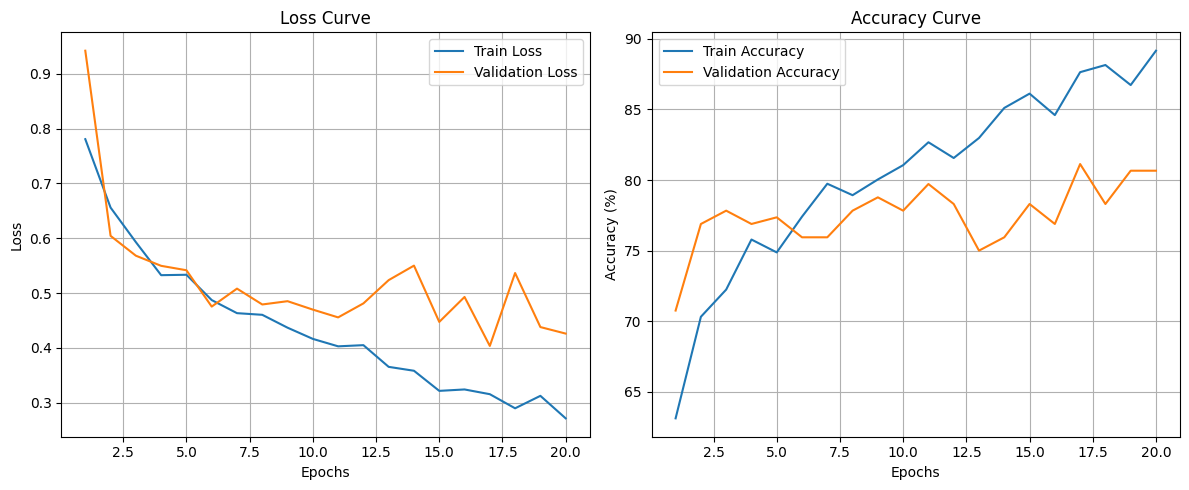

In [31]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

### 3.2. Convolutional Neural Networks in PyTorch (CNN)

#### 3.2.1. Transform Data again:

Unlike the MLP model, which requires flattening the image into a vector, CNN models maintain the original 2D image structure to better capture spatial patterns. In real-world helmet detection, helmets can appear in various orientations — from front-facing, side profiles, tilted angles, or even partially occluded views (especially when objects are cropped from larger images).

Given the relatively small size of the dataset, introducing random transformations such as horizontal flips, slight rotations, and random crops during training effectively increases data diversity. This augmentation strategy enables the model to encounter a wider variety of input scenarios, helping it generalize better and significantly improving performance on unseen data.

In [32]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),   
    transforms.Normalize(mean, std) 
])

In [33]:
# Transform data again for CNN because CNN does not need flattening
training_data = CNNDataset(X_train, y_train, common_transform=transform_train)
val_data = CNNDataset(X_val, y_val, common_transform=transform_train)
test_data = CNNDataset(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=True)
cnn_test_dataloader = DataLoader(val_data, batch_size=128, shuffle=False)

**Hyperparameter Justification**

* 4 convolutional blocks (32 → 64 → 128 → 256 filters): Dataset có complex pattern(giải thích) -> Stacking two conv layers before pooling allows the model to extract more complex hierarchical features before losing spatial resolution, which is crucial for small object detection (e.g., helmets)
* BatchNorm1d + ReLU + Dropout: reduce overfitting
* Kernel size = 5x5 at first and 3x3 for the rest:A larger kernel (5×5) in the first block captures broader context and coarse-level features from the raw input image. Subsequent 3×3 kernels focus on refining finer details, balancing computational efficiency and model expressiveness.
* Optimizer with Adam (lr=0.001): Adaptive optimization is suitable for CNNs and faster convergence without manual tuning.
* Weght decay (L2 Regularization): penalize large weights, reduce overfitting
* ReLU Activation Function: ReLU avoids the vanishing gradient problem seen in sigmoid and tanh, where gradients become tiny for large or small inputs, slowing training. Especially images with large size (256x256x3), the feature number is really large, so putational cost is a problem
* He Initialization: avoids exploding or vanishing activations across layers.
* class_weights = 1:7 -> The dataset exhibits class imbalance, with fewer No Helmet samples. Assigning a higher class weight to the No Helmet class penalizes misclassification more heavily, encouraging the model to focus on correctly identifying No Helmet instances and improving recall.

In [34]:
cnn_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=1),
    nn.BatchNorm2d(32),        
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=5, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),  # 256 -> 128

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),  # 128 -> 64

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),  # 64 -> 32

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),  # 32 -> 16

    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(57600, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

cnn_model.apply(init_weights_he)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0008, weight_decay=1e-4)
class_weights = torch.tensor([1.0, 7.0]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
lossfunction = nn.CrossEntropyLoss()

In [35]:
train_losses, val_losses, train_accuracies, val_accuracies = training_model(
    model=cnn_model,
    optimizer=optimizer,
    epochs=9,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lossfunction=lossfunction
)

Epoch 1:
Train Loss: 0.7525 | Train Accuracy: 73.96%
Val   Loss: 1.2273 | Val   Accuracy: 49.06%
--------------------------------------------------
Epoch 2:
Train Loss: 0.4429 | Train Accuracy: 80.04%
Val   Loss: 0.7227 | Val   Accuracy: 79.72%
--------------------------------------------------
Epoch 3:
Train Loss: 0.3978 | Train Accuracy: 83.69%
Val   Loss: 0.6385 | Val   Accuracy: 81.60%
--------------------------------------------------
Epoch 4:
Train Loss: 0.3462 | Train Accuracy: 86.32%
Val   Loss: 0.3677 | Val   Accuracy: 86.79%
--------------------------------------------------
Epoch 5:
Train Loss: 0.3054 | Train Accuracy: 87.74%
Val   Loss: 0.3534 | Val   Accuracy: 86.79%
--------------------------------------------------
Epoch 6:
Train Loss: 0.3205 | Train Accuracy: 87.34%
Val   Loss: 0.3861 | Val   Accuracy: 86.32%
--------------------------------------------------
Epoch 7:
Train Loss: 0.3588 | Train Accuracy: 86.93%
Val   Loss: 0.4467 | Val   Accuracy: 83.96%
---------------

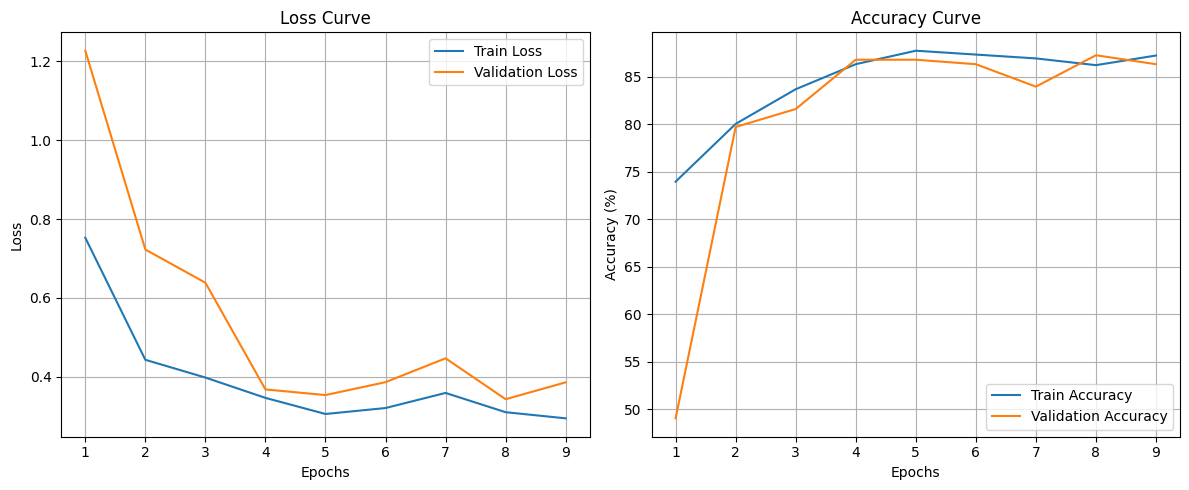

In [36]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
torch.save(cnn_model.state_dict(), "cnn_model.pth")

## Part 4 Model Evaluation and Comparison – 30%

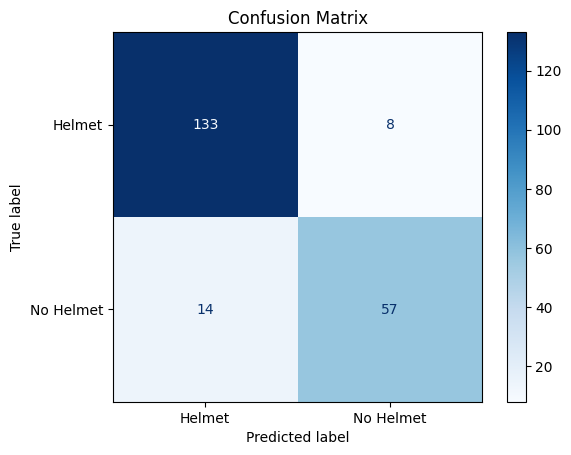

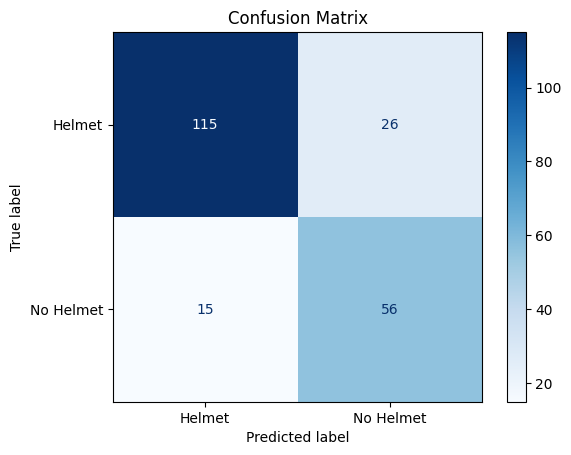

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:, 1] > 0.5).long()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
# CNN Model - Confusion Matrix
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, cnn_test_dataloader)
plot_confusion(y_true_cnn, y_pred_cnn, class_names=["Helmet", "No Helmet"])

# MLP Model - Confusion Matrix
y_true_mlp, y_pred_mlp = get_predictions(mlp_model, mlp_test_dataloader)
plot_confusion(y_true_mlp, y_pred_mlp, class_names=["Helmet", "No Helmet"])

In [38]:
from sklearn.metrics import recall_score, precision_score, f1_score

def compute_metrics(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            predicted = (probs[:, 1] > 0.5).long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    recall = recall_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    print(f"Recall (Without helmet class - label 1): {recall:.4f}")
    print(f"Precision (Without helmet class - label 1): {precision:.4f}")
    print(f"F1-Score (Without helmet class - label 1): {f1:.4f}")
print("CNN")
compute_metrics(cnn_model, cnn_test_dataloader)
print("-------------")
print("MLP")
compute_metrics(mlp_model, mlp_test_dataloader)

CNN
Recall (Without helmet class - label 1): 0.8169
Precision (Without helmet class - label 1): 0.8529
F1-Score (Without helmet class - label 1): 0.8345
-------------
MLP
Recall (Without helmet class - label 1): 0.7887
Precision (Without helmet class - label 1): 0.6829
F1-Score (Without helmet class - label 1): 0.7320


**Key Metric:** 

Given that the dataset exhibits class imbalance, relying solely on accuracy may not provide a true reflection of model performance across both classes.
If the goal of this image classification task is to serve as a foundation for helmet detection applications — such as in factories or traffic monitoring systems — recall becomes the most appropriate evaluation metric.
Recall focuses on the model's ability to correctly identify all positive cases (e.g., individuals without helmets), which is critical for ensuring safety in high-risk environments.

**Key observation:** 

From the results, it is evident that CNN substantially outperforms MLP. Several technical factors contribute to this:
* MLP flattens the image into a 1D vector, discarding the spatial structure (e.g., how edges, corners, and textures are arranged). CNN maintains the 2D spatial layout, allowing the model to detect local patterns (such as the shape of a helmet) irrespective of position or orientation.
* A fully connected MLP on 256×256×3 images would need millions of parameters, making it highly prone to overfitting with small datasets. CNNs use shared kernels (filters) across the image, drastically reducing the number of parameters and making learning more robust.

**Important Challenges Identified**
While CNN models achieve significantly better performance, out of 71 images labeled as No Helmet, 14 were incorrectly predicted as Helmet, representing approximately 19.7% of No Helmet cases. This is considered the worst-case error for this task, as failing to detect individuals without helmets could compromise safety. It is important to acknowledge issues of detecting No Helmet as Helmet label, which might be because of:

* Feature Similarity between Helmet and No Helmet: Upon testing, it was observed that the model correctly classifies individuals wearing distinct objects like caps or those with bright-colored long hair (e.g., blonde) as No Helmet. However, it struggles with individuals having dark short hair or bun hairstyles, often misclassifying them as wearing helmets. This suggests that the model excels when the object structure visibly differs from a helmet but struggles when the structure is visually similar.
* Data quality: The dataset was cropped from an object detection dataset. As a result, many cropped images suffer from issues such as blurriness, poor lighting, or a lack of clear structural distinction between helmet and no helmet instances. This likely contributes to the model’s difficulty in differentiating subtle visual cues.

Due to the prediction challenges discussed above, I have also provided a separate folder containing external test images alongside this submission.
If you wish to test using your own images, please **screenshot and crop the object to include only the head region**, as the entire dataset used for training was based on cropped head images.

Hugging_face: https://huggingface.co/spaces/demile2409/CSIS-3290-Helmet-Image-Classification